In [1]:
assets = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2020-01-01'
end_date = '2024-12-31'

In [3]:
import yfinance as yf
import pandas as pd

data = yf.download(assets, start=start_date, end=end_date)['Close']
returns = data.pct_change().dropna()

[*********************100%***********************]  3 of 3 completed


In [4]:
import numpy as np

confidence_level = 0.99
portfolio_weights = np.array([0.4, 0.4, 0.2])
portfolio_returns = returns.dot(portfolio_weights)

# 1-day VaR (Historical)
VaR_1d = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
print(f"1-day Historical VaR at {int(confidence_level*100)}% confidence: {VaR_1d:.4%}")

1-day Historical VaR at 99% confidence: -4.7223%


In [5]:
# Confidence level (same as VaR)
confidence_level = 0.99

# Portfolio returns already calculated in Step 1
# portfolio_returns = returns.dot(portfolio_weights)

# Calculate VaR threshold
VaR_threshold = np.percentile(portfolio_returns, (1 - confidence_level) * 100)

# Filter returns that are worse (i.e., more negative) than the VaR threshold
tail_losses = portfolio_returns[portfolio_returns <= VaR_threshold]

# Calculate Expected Shortfall (i.e., average of losses worse than VaR)
expected_shortfall = tail_losses.mean()

print(f"1-day Expected Shortfall (CVaR) at {int(confidence_level * 100)}% confidence: {expected_shortfall:.4%}")

1-day Expected Shortfall (CVaR) at 99% confidence: -6.3898%


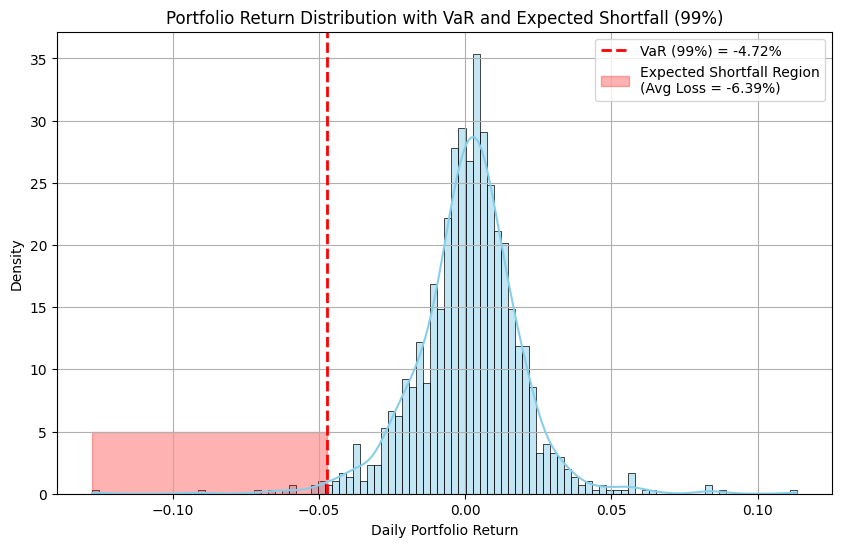

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of portfolio returns
plt.figure(figsize=(10, 6))
sns.histplot(portfolio_returns, bins=100, kde=True, color='skyblue', stat="density")

# Plot VaR
plt.axvline(VaR_threshold, color='red', linestyle='--', linewidth=2, label=f'VaR ({confidence_level*100:.0f}%) = {VaR_threshold:.2%}')

# Shade the Expected Shortfall region
plt.fill_betweenx(
    y=[0, 5],  # vertical range for shading
    x1=portfolio_returns.min(),
    x2=VaR_threshold,
    color='red',
    alpha=0.3,
    label=f'Expected Shortfall Region\n(Avg Loss = {expected_shortfall:.2%})'
)

plt.title(f"Portfolio Return Distribution with VaR and Expected Shortfall ({int(confidence_level*100)}%)")
plt.xlabel("Daily Portfolio Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Estimate mean and std dev from historical returns
mu = portfolio_returns.mean()
sigma = portfolio_returns.std()

# Simulate 10,000 daily returns
n_simulations = 10000
simulated_returns = np.random.normal(loc=mu, scale=sigma, size=n_simulations)

# Compute Monte Carlo VaR and ES
mc_VaR = np.percentile(simulated_returns, (1 - confidence_level) * 100)
mc_ES = simulated_returns[simulated_returns <= mc_VaR].mean()

print(f"Monte Carlo 1-day VaR (99%): {mc_VaR:.4%}")
print(f"Monte Carlo 1-day Expected Shortfall (99%): {mc_ES:.4%}")

Monte Carlo 1-day VaR (99%): -4.0222%
Monte Carlo 1-day Expected Shortfall (99%): -4.5925%


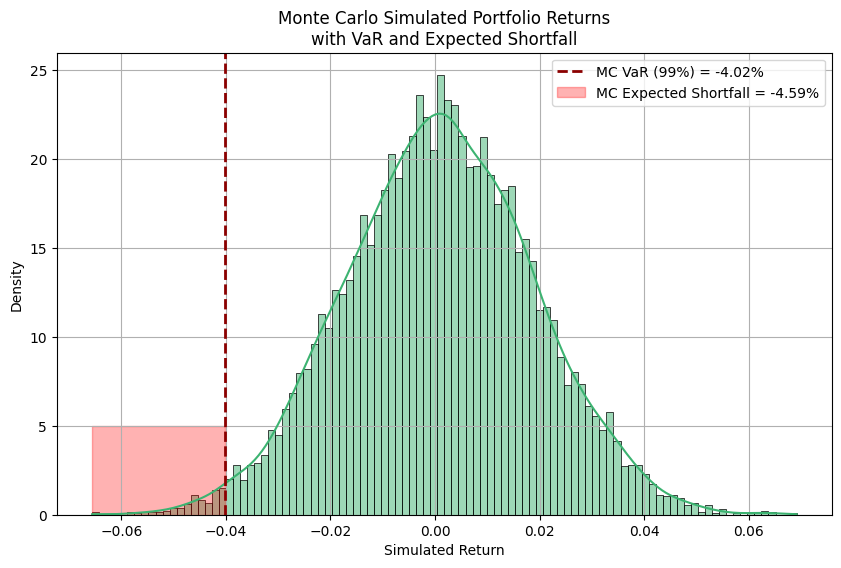

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(simulated_returns, bins=100, kde=True, color='mediumseagreen', stat='density')
plt.axvline(mc_VaR, color='darkred', linestyle='--', linewidth=2, label=f'MC VaR ({confidence_level*100:.0f}%) = {mc_VaR:.2%}')
plt.fill_betweenx([0, 5], simulated_returns.min(), mc_VaR, color='red', alpha=0.3, label=f'MC Expected Shortfall = {mc_ES:.2%}')
plt.title("Monte Carlo Simulated Portfolio Returns\nwith VaR and Expected Shortfall")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Assuming you already have these values from previous steps:
# Historical VaR & ES
hist_VaR = VaR_1d
hist_ES = expected_shortfall

# Monte Carlo VaR & ES
mc_VaR = np.percentile(simulated_returns, (1 - confidence_level) * 100)
mc_ES = simulated_returns[simulated_returns <= mc_VaR].mean()

# Display both
comparison_df = pd.DataFrame({
    'Method': ['Historical', 'Monte Carlo (Normal)'],
    'VaR (99%)': [hist_VaR, mc_VaR],
    'Expected Shortfall (99%)': [hist_ES, mc_ES]
})

# Format as %
comparison_df[['VaR (99%)', 'Expected Shortfall (99%)']] = comparison_df[['VaR (99%)', 'Expected Shortfall (99%)']].applymap(lambda x: f"{x:.2%}")
print(comparison_df)

                 Method VaR (99%) Expected Shortfall (99%)
0            Historical    -4.72%                   -6.39%
1  Monte Carlo (Normal)    -4.02%                   -4.59%


C:\Users\Lenevo\AppData\Local\Temp\ipykernel_8052\149763541.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  comparison_df[['VaR (99%)', 'Expected Shortfall (99%)']] = comparison_df[['VaR (99%)', 'Expected Shortfall (99%)']].applymap(lambda x: f"{x:.2%}")


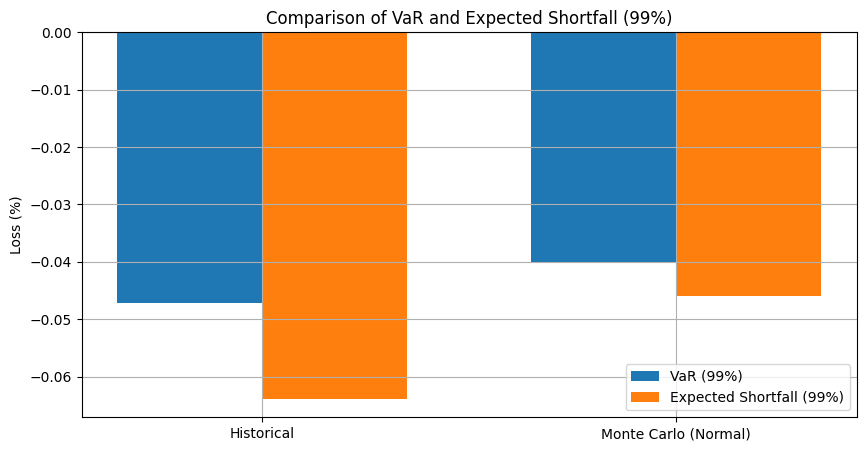

In [10]:
plt.figure(figsize=(10, 5))
methods = ['Historical', 'Monte Carlo (Normal)']
x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, [hist_VaR, mc_VaR], width, label='VaR (99%)')
plt.bar(x + width/2, [hist_ES, mc_ES], width, label='Expected Shortfall (99%)')

plt.xticks(x, methods)
plt.ylabel('Loss (%)')
plt.title('Comparison of VaR and Expected Shortfall (99%)')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import scipy.stats as stats

# Parameters
df = 5  # degrees of freedom for Student's t (fat tails)
mu = portfolio_returns.mean()
sigma = portfolio_returns.std()
n_simulations = 10000

# Simulate from Student's t, then scale
t_samples = stats.t.rvs(df, size=n_simulations)
scaled_returns = mu + t_samples * (sigma / np.sqrt(df / (df - 2)))  # scale to match normal std

# Compute t-distribution VaR and ES
t_VaR = np.percentile(scaled_returns, (1 - confidence_level) * 100)
t_ES = scaled_returns[scaled_returns <= t_VaR].mean()

print(f"Student's t Monte Carlo VaR (99%): {t_VaR:.4%}")
print(f"Student's t Monte Carlo Expected Shortfall (99%): {t_ES:.4%}")

Student's t Monte Carlo VaR (99%): -4.6959%
Student's t Monte Carlo Expected Shortfall (99%): -6.0838%


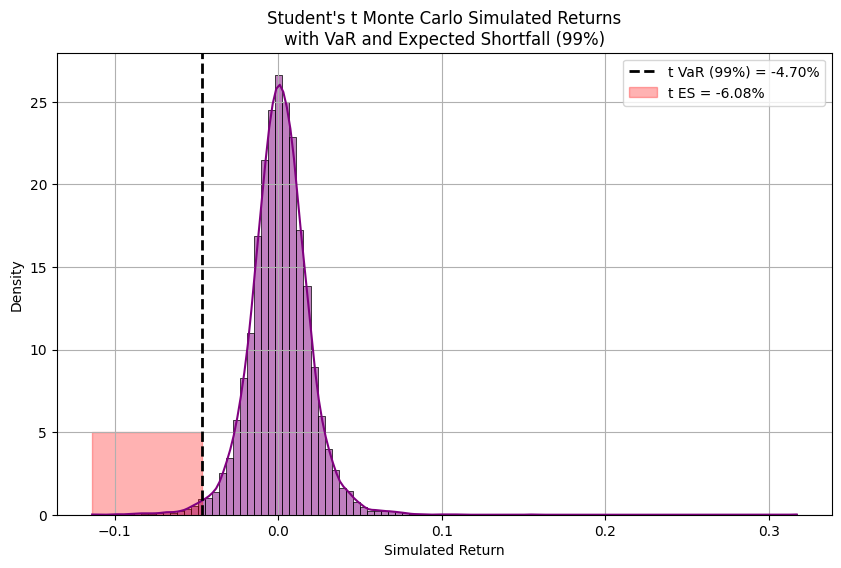

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(scaled_returns, bins=100, kde=True, color='purple', stat='density')
plt.axvline(t_VaR, color='black', linestyle='--', linewidth=2, label=f"t VaR (99%) = {t_VaR:.2%}")
plt.fill_betweenx([0, 5], scaled_returns.min(), t_VaR, color='red', alpha=0.3, label=f"t ES = {t_ES:.2%}")
plt.title("Student's t Monte Carlo Simulated Returns\nwith VaR and Expected Shortfall (99%)")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
S0 = 1.0  # Current portfolio value (normalize to 1)
K = 0.95  # Strike price (5% OTM)
T = 1/252  # Time to maturity (1 day)
r = 0.01  # Risk-free rate
sigma = portfolio_returns.std() * np.sqrt(252)  # Annualized volatility

In [14]:
from scipy.stats import norm

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

In [15]:
# Get put option price
put_price = black_scholes_put(S0, K, T, r, sigma)

# Simulated portfolio returns (e.g. use your Student-t simulated returns)
simulated_end_values = S0 * (1 + scaled_returns)
payoff = np.maximum(K - simulated_end_values, 0)
hedged_values = simulated_end_values + payoff - put_price
hedged_returns = (hedged_values - S0) / S0

In [16]:
hedged_VaR = np.percentile(hedged_returns, (1 - confidence_level) * 100)
hedged_ES = hedged_returns[hedged_returns <= hedged_VaR].mean()

print(f"Hedged VaR (99%): {hedged_VaR:.4%}")
print(f"Hedged Expected Shortfall (99%): {hedged_ES:.4%}")


Hedged VaR (99%): -4.6970%
Hedged Expected Shortfall (99%): -4.9641%


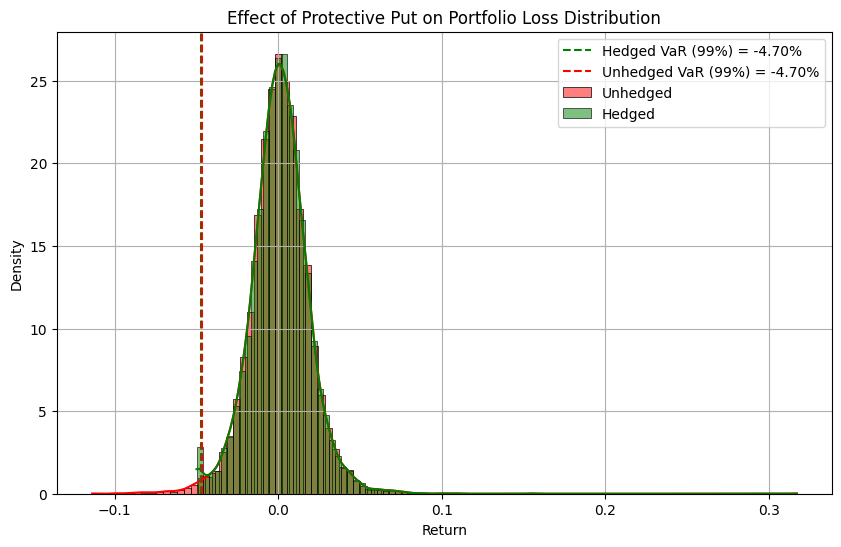

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(scaled_returns, bins=100, kde=True, stat='density', color='red', label='Unhedged', alpha=0.5)
sns.histplot(hedged_returns, bins=100, kde=True, stat='density', color='green', label='Hedged', alpha=0.5)
plt.axvline(hedged_VaR, color='green', linestyle='--', label=f"Hedged VaR (99%) = {hedged_VaR:.2%}")
plt.axvline(t_VaR, color='red', linestyle='--', label=f"Unhedged VaR (99%) = {t_VaR:.2%}")
plt.title("Effect of Protective Put on Portfolio Loss Distribution")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
from arch import arch_model

# Fit model
garch_model = arch_model(portfolio_returns * 100, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

In [25]:
# Forecast volatility (1-day ahead, 10,000 paths)
simulations = garch_result.forecast(horizon=1, method='simulation', simulations=10000)
simulated_vols = simulations.variance.values[-1, :] ** 0.5 / 100
simulated_returns = np.random.normal(0, simulated_vols)

In [26]:
var_garch = np.percentile(simulated_returns, 1)
es_garch = simulated_returns[simulated_returns <= var_garch].mean()

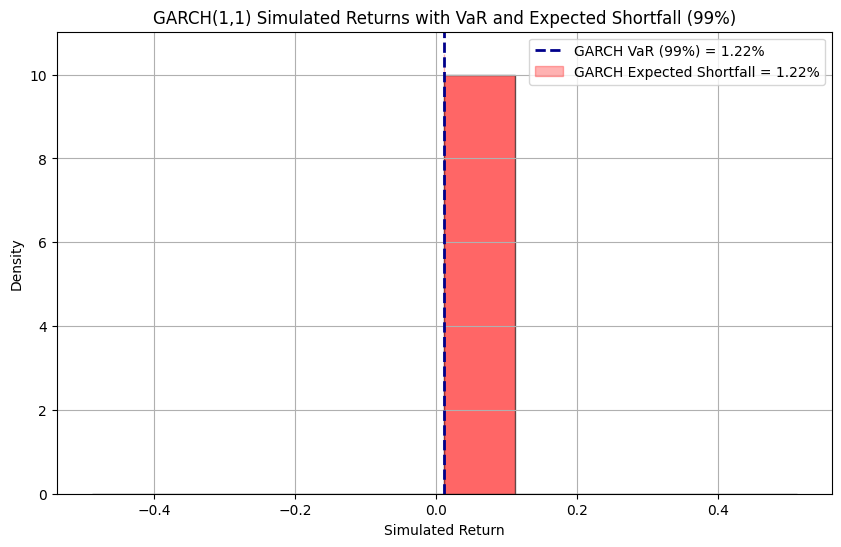

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# === Assuming you already have this ===
# simulated_returns = np.random.normal(0, simulated_vols)  # From GARCH step

# Step 1: Compute GARCH VaR and ES (99%)
var_garch = np.percentile(simulated_returns, 1)
es_garch = simulated_returns[simulated_returns <= var_garch].mean()

# Step 2: Plot histogram of simulated returns
plt.figure(figsize=(10, 6))
plt.hist(simulated_returns, bins=10, density=True, color='red', edgecolor='k', alpha=0.6)

# Step 3: Plot VaR line
plt.axvline(var_garch, color='darkblue', linestyle='--', linewidth=2, label=f'GARCH VaR (99%) = {var_garch:.2%}')

# Step 4: Shade Expected Shortfall region
plt.fill_betweenx(y=[0, plt.gca().get_ylim()[1]],
                  x1=min(simulated_returns), x2=var_garch,
                  color='red', alpha=0.3, label=f'GARCH Expected Shortfall = {es_garch:.2%}')

# Step 5: Formatting
plt.title("GARCH(1,1) Simulated Returns with VaR and Expected Shortfall (99%)")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.show()


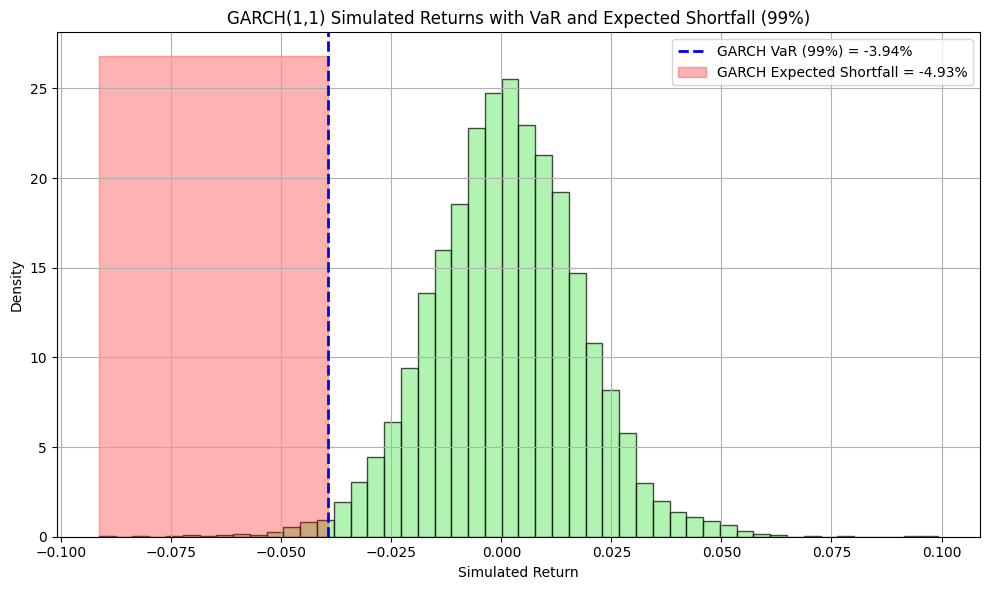

In [37]:
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Fit GARCH(1,1) to portfolio returns (scale *100 for percent returns)
model = arch_model(portfolio_returns * 100, vol='GARCH', p=1, q=1, mean='Constant')
res = model.fit(disp='off')

# Step 2: Simulate 10,000 one-step returns manually using model.simulate()
n_simulations = 10000
simulated_returns = []

for _ in range(n_simulations):
    sim = model.simulate(params=res.params, nobs=1)  # no invalid keywords here
    simulated_returns.append(sim['data'].iloc[0])

# Convert to numpy array and back to decimal form
simulated_returns = np.array(simulated_returns) / 100

# Step 3: Calculate VaR and Expected Shortfall at 99%
var_99 = np.percentile(simulated_returns, 1)
es_99 = simulated_returns[simulated_returns <= var_99].mean()

# Step 4: Plot histogram with VaR and ES
plt.figure(figsize=(10, 6))
plt.hist(simulated_returns, bins=50, density=True, color='lightgreen', edgecolor='k', alpha=0.7)

plt.axvline(var_99, color='blue', linestyle='--', linewidth=2, label=f'GARCH VaR (99%) = {var_99:.2%}')
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], min(simulated_returns), var_99,
                  color='red', alpha=0.3, label=f'GARCH Expected Shortfall = {es_99:.2%}')

plt.title("GARCH(1,1) Simulated Returns with VaR and Expected Shortfall (99%)")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


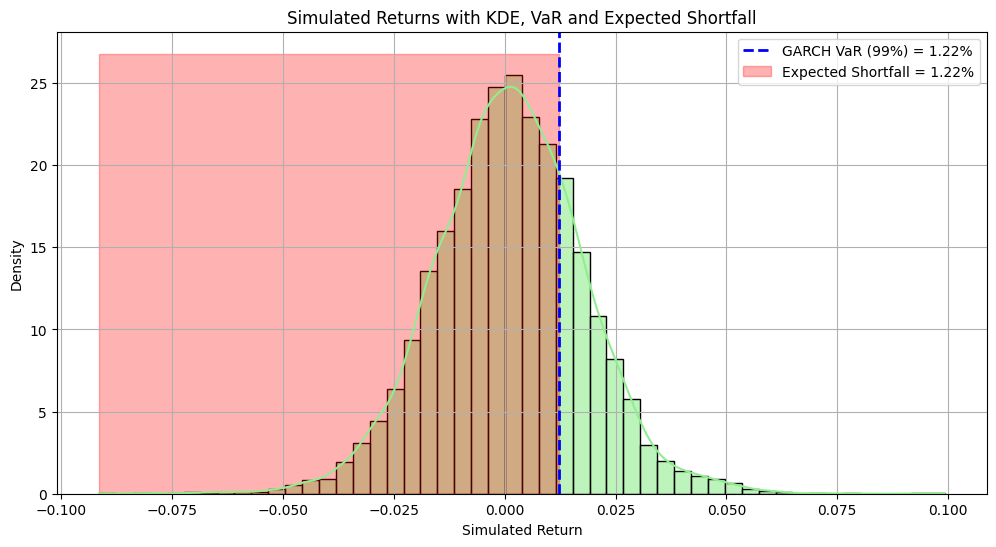

In [38]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(simulated_returns, bins=50, kde=True, stat='density', color='lightgreen', edgecolor='k', alpha=0.6)

# VaR and ES lines
plt.axvline(var_garch, color='blue', linestyle='--', linewidth=2, label=f'GARCH VaR (99%) = {var_garch:.2%}')
plt.fill_betweenx(y=[0, plt.gca().get_ylim()[1]], x1=min(simulated_returns), x2=var_garch,
                  color='red', alpha=0.3, label=f'Expected Shortfall = {es_garch:.2%}')

plt.title("Simulated Returns with KDE, VaR and Expected Shortfall")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
from arch import arch_model

# Fit Student-t GARCH(1,1)
model_t = arch_model(portfolio_returns * 100, vol='Garch', p=1, q=1, dist='t')
res_t = model_t.fit(disp='off')

# Simulate from the Student-t model
simulated_returns_t = []
for _ in range(10000):
    sim = model_t.simulate(res_t.params, nobs=1)
    simulated_returns_t.append(sim['data'].values[0])
simulated_returns_t = np.array(simulated_returns_t) / 100

# Compute VaR and ES
var_t = np.percentile(simulated_returns_t, 1)
es_t = simulated_returns_t[simulated_returns_t <= var_t].mean()


In [40]:
var_10d = var_garch * np.sqrt(10)
es_10d = es_garch * np.sqrt(10)


In [41]:
ten_day_returns = []
for _ in range(10000):
    sim = model.simulate(res.params, nobs=10)
    ten_day_returns.append(sim['data'].sum())  # Aggregate returns over 10 days

ten_day_returns = np.array(ten_day_returns) / 100
var_10d_mc = np.percentile(ten_day_returns, 1)
es_10d_mc = ten_day_returns[ten_day_returns <= var_10d_mc].mean()


In [42]:
# Historical 1-day VaR
hist_var = np.percentile(portfolio_returns, 1)
hist_es = portfolio_returns[portfolio_returns <= hist_var].mean()

print(f"Historical VaR (99%): {hist_var:.2%}")
print(f"GARCH VaR (99%): {var_garch:.2%}")


Historical VaR (99%): -4.72%
GARCH VaR (99%): 1.22%


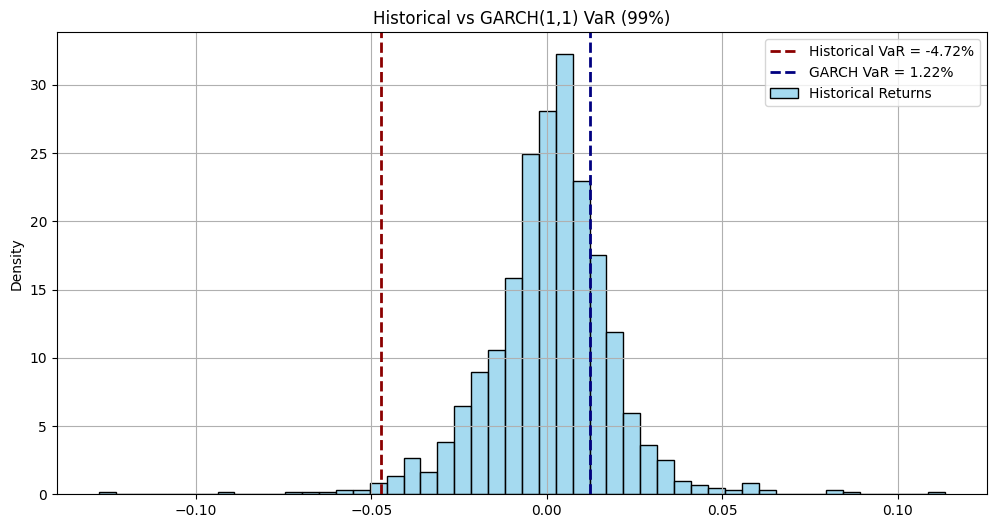

In [43]:
plt.figure(figsize=(12, 6))
sns.histplot(portfolio_returns, bins=50, stat='density', color='skyblue', edgecolor='k', label='Historical Returns')
plt.axvline(hist_var, color='darkred', linestyle='--', linewidth=2, label=f'Historical VaR = {hist_var:.2%}')
plt.axvline(var_garch, color='navy', linestyle='--', linewidth=2, label=f'GARCH VaR = {var_garch:.2%}')
plt.title("Historical vs GARCH(1,1) VaR (99%)")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
import yfinance as yf
import pandas as pd
import numpy as np

# Example: Get historical data for 3 assets
tickers = ['AAPL', 'MSFT', 'GOOGL']
data = yf.download(tickers, start='2020-01-01', end='2024-12-31')['Close']
returns = data.pct_change().dropna()


[*********************100%***********************]  3 of 3 completed


In [46]:
from scipy.stats import rankdata

# Convert to uniform margins using empirical CDF (pseudo-observations)
u = returns.apply(lambda x: rankdata(x) / (len(x) + 1), axis=0)


In [50]:
pip install copulas

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
    --------------------------------------- 0.3/14.8 MB ? eta -:--:--
   -- ------------------------------------- 0.8/14.8 MB 1.8 MB/s eta 0:00:08
   -- ------------------------------------- 1.0/14.8 MB 1.9 MB/s eta 0:00:08
   ---- ----------------------------------- 1.6/14.8 MB 1.9 MB/s eta 0:00:07
   ----- ---------------------------------- 2.1/14.8 MB 2.0 MB/s eta 0:00:07
   ------ --------------------------------- 2.4/14.8 MB 2.0 MB/s eta 0:00:07
   ------ --------------------------------- 2.4/14.8 MB 2.0 MB/s eta 0:00:07
   ------ --------------------------------- 2.4/14.8 MB 2.0 MB/s eta 0:00:07
   ------- -------------------------------- 2.6/14.8 MB 1.3 MB/s eta 0:00:10
   ---------- ----------------------------- 3.9/14.8 MB 1.8 MB/s eta 0:00:06
   -------------- ------------------------- 5.2/14.8 MB 2.3 MB/s eta 0:00:05
   ---------

In [51]:
from copulas.multivariate import GaussianMultivariate

# Fit copula to uniform marginals
copula = GaussianMultivariate()
copula.fit(u)

C:\Users\Lenevo\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:6338: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
C:\Users\Lenevo\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:6338: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
C:\Users\Lenevo\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:6338: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)


In [52]:
n_simulations = 10000
simulated_u = copula.sample(n_simulations)


In [53]:
from scipy.stats import norm

# Apply inverse CDF (quantile) from historical marginals
simulated_returns = pd.DataFrame(index=range(n_simulations), columns=returns.columns)

for col in returns.columns:
    quantiles = returns[col].quantile(simulated_u[col])
    simulated_returns[col] = quantiles.values


In [54]:
# Define weights
weights = np.array([0.4, 0.4, 0.2])  # Example weights

# Portfolio returns
portfolio_sim = simulated_returns.dot(weights)

# Compute VaR and Expected Shortfall
var_copula = np.percentile(portfolio_sim, 1)
es_copula = portfolio_sim[portfolio_sim <= var_copula].mean()


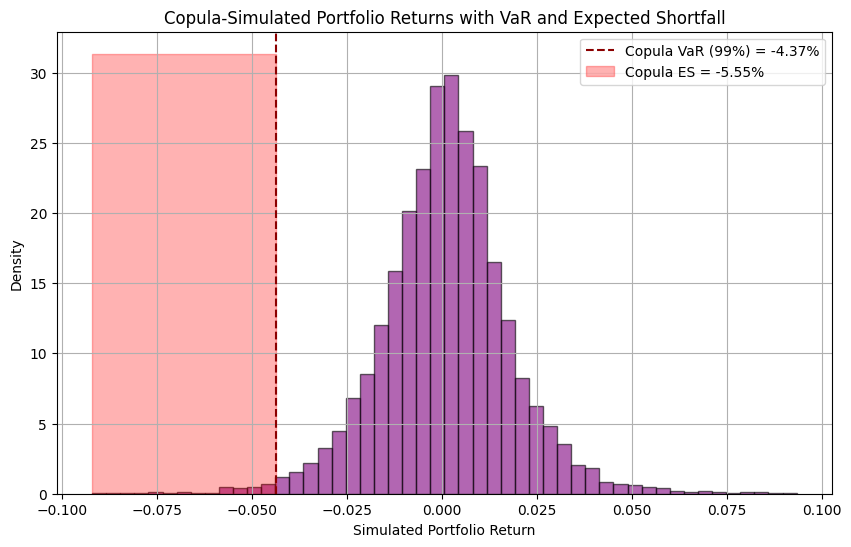

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(portfolio_sim, bins=50, density=True, alpha=0.6, color='purple', edgecolor='black')
plt.axvline(var_copula, color='darkred', linestyle='--', label=f'Copula VaR (99%) = {var_copula:.2%}')
plt.fill_betweenx(y=[0, plt.gca().get_ylim()[1]], x1=min(portfolio_sim), x2=var_copula,
                  color='red', alpha=0.3, label=f'Copula ES = {es_copula:.2%}')
plt.title("Copula-Simulated Portfolio Returns with VaR and Expected Shortfall")
plt.xlabel("Simulated Portfolio Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [57]:
from scipy.stats import genpareto
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract losses (left tail)
losses = -portfolio_returns  # convert to losses
threshold = np.quantile(losses, 0.95)  # use 95% quantile as threshold
excess_losses = losses[losses > threshold] - threshold

# Step 2: Fit GPD
params = genpareto.fit(excess_losses)  # (shape, loc, scale)
shape, loc, scale = params

# Step 3: Estimate EVT-based VaR and ES at 99%
p = 0.99
n = len(losses)
nu = len(excess_losses)
quantile_level = (1 - p) / (nu / n)

# VaR EVT
VaR_evt = threshold + (scale / shape) * ((quantile_level ** (-shape)) - 1)

# ES EVT
ES_evt = (VaR_evt + scale - shape * threshold) / (1 - shape) if shape < 1 else np.nan

print(f"EVT VaR (99%): {-VaR_evt:.2%}")
print(f"EVT ES  (99%): {-ES_evt:.2%}")


EVT VaR (99%): -4.98%
EVT ES  (99%): -8.32%


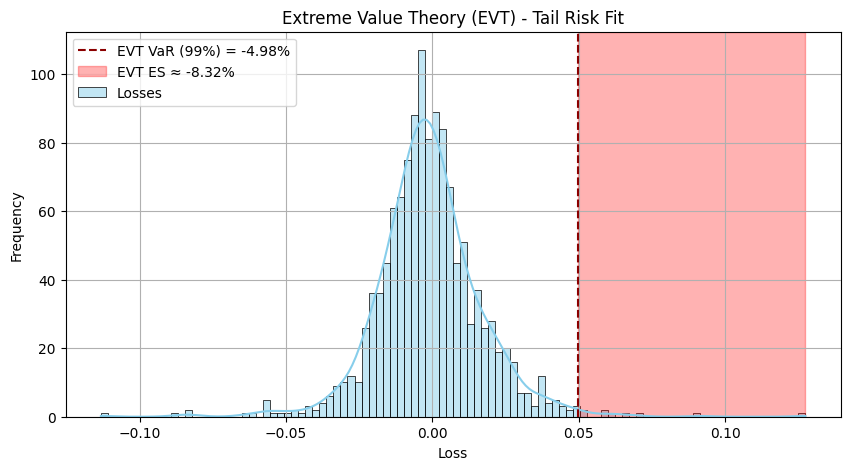

In [58]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(losses, bins=100, kde=True, color='skyblue', label='Losses')
plt.axvline(VaR_evt, color='darkred', linestyle='--', label=f'EVT VaR (99%) = {-VaR_evt:.2%}')
plt.axvspan(VaR_evt, max(losses), color='red', alpha=0.3, label=f'EVT ES ≈ {-ES_evt:.2%}')
plt.title('Extreme Value Theory (EVT) - Tail Risk Fit')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


In [61]:
# Assuming `historical_returns` and `historical_var` are already defined
# Check where actual losses exceed VaR (i.e., violations)

violations = historical_returns < historical_var
violation_count = violations.sum()
total_obs = len(historical_returns)
violation_rate = violation_count / total_obs

print(f"Total observations: {total_obs}")
print(f"VaR Violations: {violation_count}")
print(f"Violation Rate: {violation_rate:.2%}")


NameError: name 'historical_returns' is not defined